In [16]:
import numpy as np 
import pandas as pd
import xarray as xr
import openpyxl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import *
import matplotlib.colors as colors
from scipy import stats 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point


In [17]:
path="/bettik/PROJECTS/pr-regional-climate/santolam/glacioclim/donnees_meteo/MeraSummit_2013-16.xlsx"
xl_data=pd.ExcelFile(path)                           
#print(xl_data)                                       

In [18]:
dfs = {sheet_name: xl_data.parse(sheet_name)     
       for sheet_name in xl_data.sheet_names}
Data=dfs['MeraSummit2013_16']                  

In [19]:
NameVars=['Time','Tairlow','RHlow','Tairhight','RHhight','u','Direction','SWin','SWout','LWincor','LWoutcor','T1snow','T2snow','T3snow','T4snow','T5snow','T6snow','Abl/acc dist sensor surf','Quality number SR50','Patm']

UnitVars=['data/hour','C','%','C','%','m/s','degrees','W/m2','W/m2','W/m2','W/m2','C','C','C','C','C','C','m','','hPa']



In [20]:

##Define new DataFrame and changing name of columns
dfile= pd.DataFrame(data=Data.loc[4:]) 
df=pd.DataFrame(dfile.values, columns=NameVars) 
### Opening one column + converting into an array
Tairlow_ar=[float(i) for i in df.Tairlow.values]   #Convertit les données en float utilisables 
Tairhight_ar=[float(i) for i in df.Tairhight.values] 

In [21]:
#Pour l'utilisation des données avec xarray, redéfinitions des variables en prenant en compte la fréquence à laquelle les données sont prises ( ici 30 min ) 
def NewTime(
        NameVar,
        Var_ar,
        freq):
    start, end = df.Time.values[0], df.Time.values[-1]
    time = pd.date_range(start, end, freq=freq)
    ds = xr.Dataset({NameVar: ("time",np.asarray(Var_ar)), "time": time})
    return ds 
    
Tlow=NewTime('Tairlow',Tairlow_ar,'30min')
Thight=NewTime('Tairhight',Tairhight_ar,'30min')
T=xr.Dataset()
T['Tair']=((Tlow.Tairlow+Thight.Tairhight)/2)

In [22]:
daily_meanT=T.resample(time='D').mean()

monthly_meanT=daily_meanT.resample(time='ME').mean()   

yearly_meanT=monthly_meanT.resample(time='YE').mean()


In [23]:
#Définition des Saisons, et création d'une fonction qui définit les saisons en fonction des périodes des moussons:
seasons = {
	'MAM': [3, 4, 5],  	
	'JJAS': [6, 7, 8, 9],  
	'ON': [10, 11],    	
	'DJF': [12, 1, 2]  	
}
def seasonsdata(ds, season_name):  #monthly_meanTM.sel(time=monthly_meanTM['time'].dt.month.isin(seasons['MAM'])). Sélectionne dans le dataset les mois correspondants aux saisons définies au dessus

	x = seasons[season_name]
	return ds.sel(time=ds['time'].dt.month.isin(x))


In [31]:
T_premon = seasonsdata(monthly_meanT, 'MAM').resample(time='YE').mean() # T moyen de chaque saison 
T_mon = seasonsdata(monthly_meanT, 'JJAS').resample(time='YE').mean()
T_postmon =  seasonsdata(monthly_meanT, 'ON').resample(time='YE').mean()
T_hiver  = seasonsdata(monthly_meanT, 'DJF').resample(time='YE').mean()

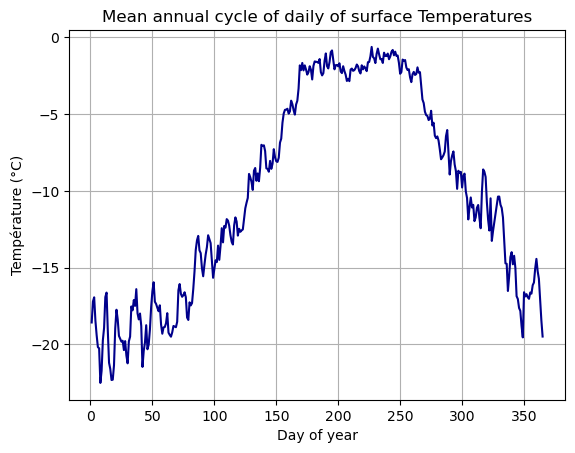

In [32]:
Tannual=daily_meanT.groupby('time.dayofyear').mean()
plt.plot(Tannual.dayofyear,Tannual.Tair,
         
    color='darkblue',linestyle='-',label='Tair')
plt.title('Mean annual cycle of daily of surface Temperatures')
plt.xlabel('Day of year')
plt.ylabel('Température (°C)')

plt.grid(True)

In [48]:
xtime=np.arange(2013,2016+1,1)
xtime_premon=np.arange(2014,2016+1,1)
xtime_mon=np.arange(2014,2016+1,1)
xtime_postmon =np.arange(2014,2016+1,1)
xtime_hiver=np.arange(2013,2016+1,1)
print(len(xtime_premon), len(xtime_postmon), len(xtime_mon), len(xtime_hiver))

3 3 3 4


In [49]:
print(len(T_premon), len(T_postmon), len(T_mon), len(T_hiver))

1 1 1 1


In [50]:
linT_mon = stats.linregress(xtime_mon,T_mon['Tair'].values)
linT_postmon = stats.linregress(xtime_postmon,T_postmon['Tair'].values)
linT_premon = stats.linregress(xtime_premon,T_premon['Tair'].values)
linT_hiver = stats.linregress(xtime_hiver,T_hiver['Tair'].values)

In [52]:
linT_mon, linT_hiver, linT_postmon, linT_premon

(LinregressResult(slope=np.float64(1.1327502123828235), intercept=np.float64(-2284.8773320007836), rvalue=np.float64(0.9950330090049456), pvalue=np.float64(0.06347778038182625), stderr=np.float64(0.11332308616512864), intercept_stderr=np.float64(228.34603736931507)),
 LinregressResult(slope=np.float64(0.04747032962836926), intercept=np.float64(-113.7887868588687), rvalue=np.float64(0.16020253889964206), pvalue=np.float64(0.8397974611003579), stderr=np.float64(0.20681976459844165), intercept_stderr=np.float64(416.6384799495289)),
 LinregressResult(slope=np.float64(nan), intercept=np.float64(nan), rvalue=np.float64(nan), pvalue=np.float64(nan), stderr=np.float64(nan), intercept_stderr=np.float64(nan)),
 LinregressResult(slope=np.float64(0.8819976459826764), intercept=np.float64(-1790.3606970606418), rvalue=np.float64(0.9643903872998183), pvalue=np.float64(0.17040251403691156), stderr=np.float64(0.24188674947019226), intercept_stderr=np.float64(487.40184019678634)))

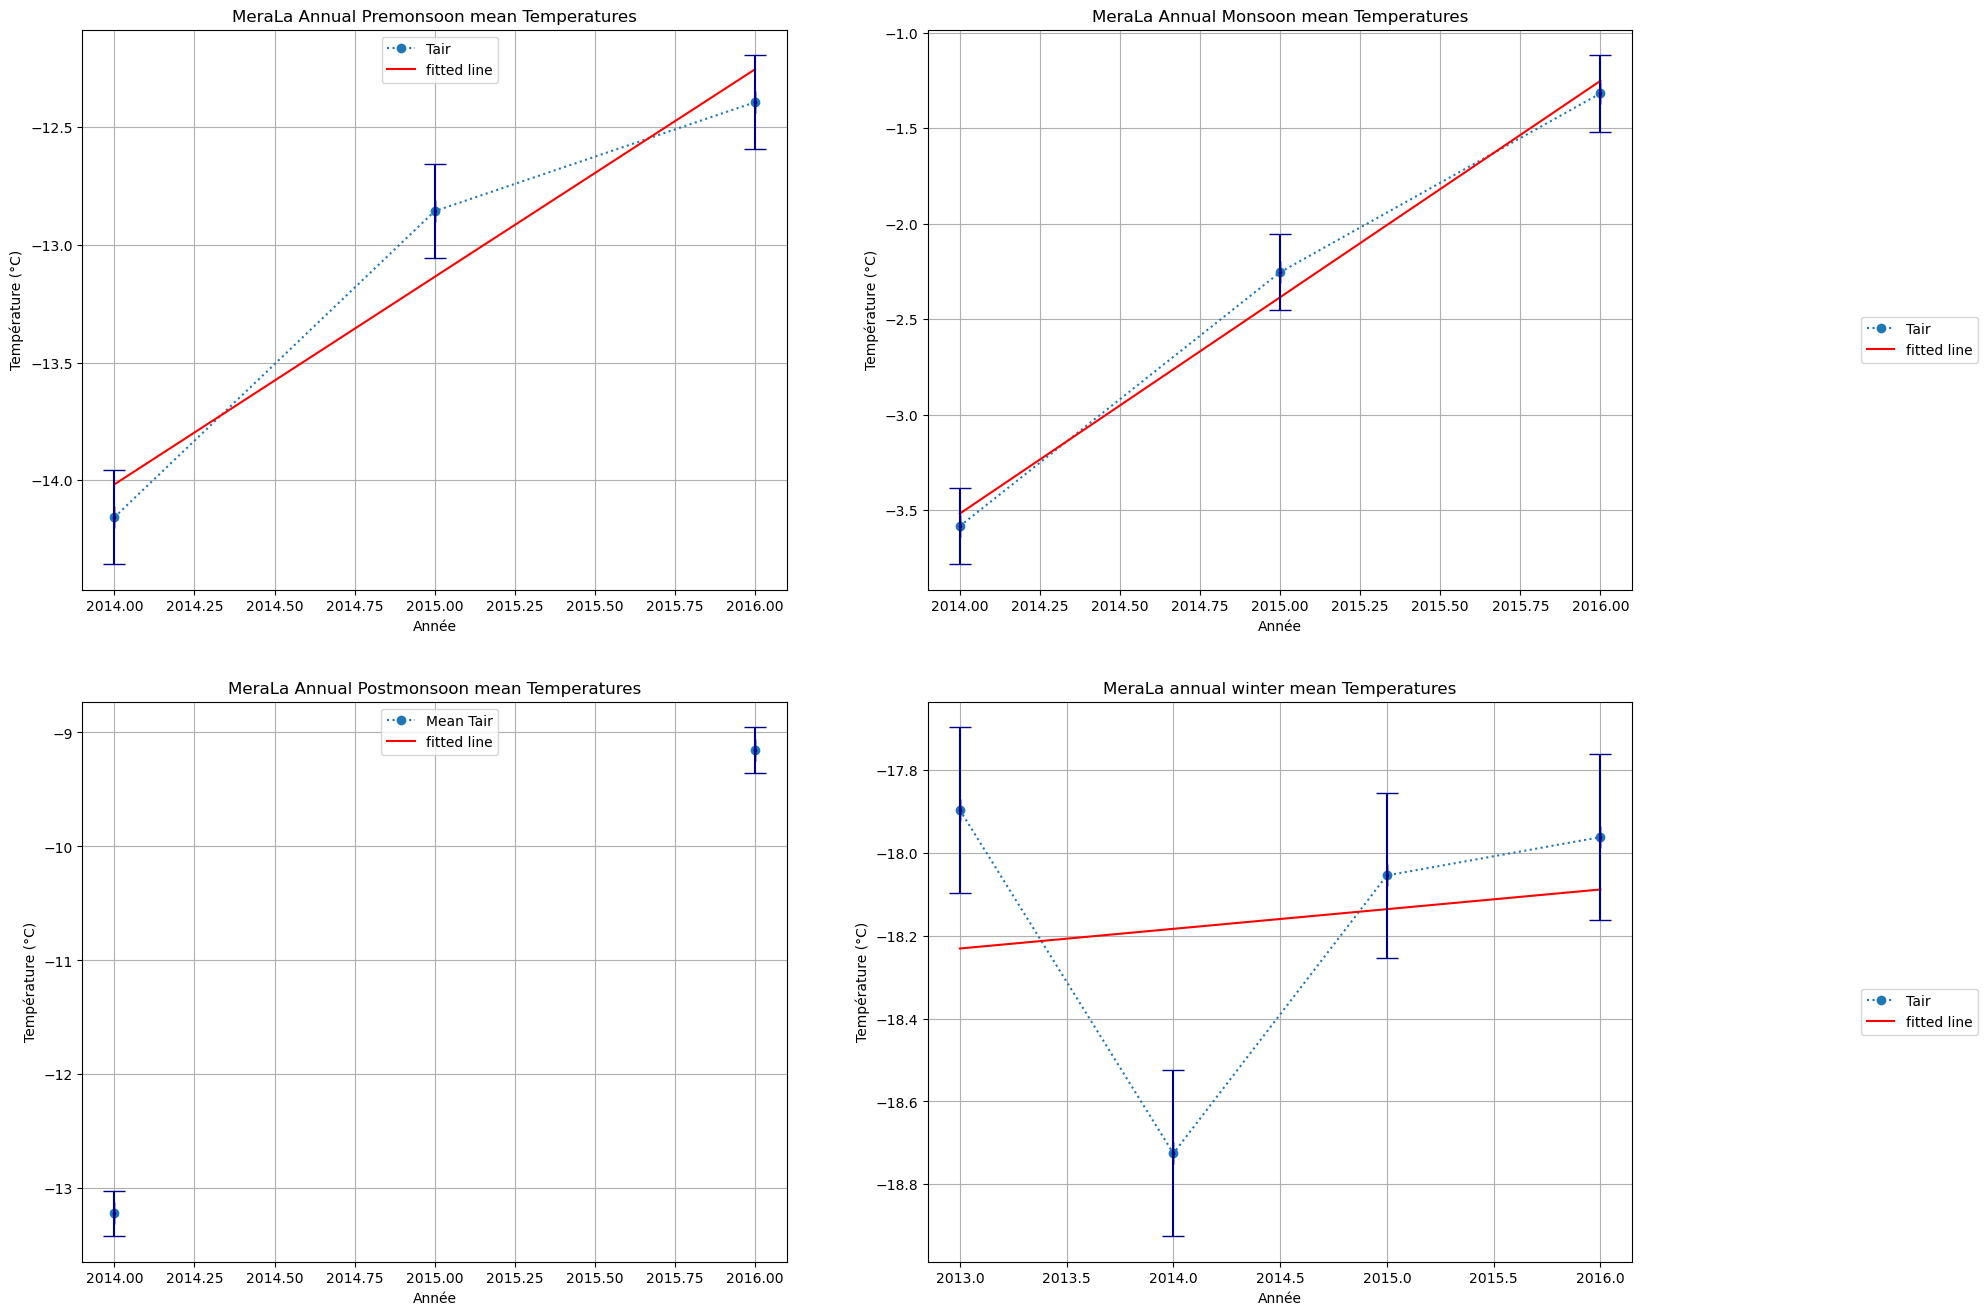

In [57]:
fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(xtime_premon, T_premon['Tair'].values, linestyle=':', marker= 'o', label='Tair')
ax1.plot(xtime_premon, linT_premon.intercept + linT_premon.slope*xtime_premon, 'r', label='fitted line')
ax1.errorbar(xtime_premon,T_premon['Tair'].values, xerr=0, yerr=0.2, marker="d",
            markersize=2,
            linestyle="none",
            color="darkblue",
            capsize=8)
ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('MeraLa Annual Premonsoon mean Temperatures')
ax1.set_xlabel('Année')
ax1.set_ylabel('Température (°C)')
ax1.grid()

ax2.plot(xtime_mon, T_mon['Tair'].values,linestyle=':', marker= 'o', label='Tair')
ax2.plot(xtime_mon, linT_mon.intercept + linT_mon.slope*xtime_mon, 'r', label='fitted line')
ax2.errorbar(xtime_mon,T_mon['Tair'].values, xerr=0, yerr=0.2, marker="d",
            markersize=2,
            linestyle="none",
            color="darkblue",
            capsize=8)
ax2.legend(bbox_to_anchor=(1, 0, 0.5, 0.5)) 
ax2.set_title('MeraLa Annual Monsoon mean Temperatures')
ax2.set_xlabel('Année')
ax2.set_ylabel('Température (°C)')
ax2.grid()

ax3.plot(xtime_postmon, T_postmon['Tair'].values,linestyle=':', marker= 'o', label='Mean Tair')
ax3.plot(xtime_postmon, linT_postmon.intercept + linT_postmon.slope*xtime_postmon, 'r', label='fitted line')
ax3.errorbar(xtime_postmon,T_postmon['Tair'].values, xerr=0, yerr=0.2, marker="d",
            markersize=2,
            linestyle="none",
            color="darkblue",
            capsize=8)
ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('MeraLa Annual Postmonsoon mean Temperatures')
ax3.set_xlabel('Année')
ax3.set_ylabel('Température (°C)')
ax3.grid()

ax4.plot(xtime_hiver, T_hiver['Tair'].values,linestyle=':', marker= 'o', label='Tair')
ax4.plot(xtime_hiver, linT_hiver.intercept + linT_hiver.slope*xtime_hiver, 'r', label='fitted line')
ax4.errorbar(xtime_hiver,T_hiver['Tair'].values, xerr=0, yerr=0.2, marker="d",
            markersize=2,
            linestyle="none",
            color="darkblue",
            capsize=8)
ax4.legend(bbox_to_anchor=(1, 0, 0.5, 0.5)) 
ax4.set_title('MeraLa annual winter mean Temperatures')
ax4.set_xlabel('Année')
ax4.set_ylabel('Température (°C)')
ax4.grid()

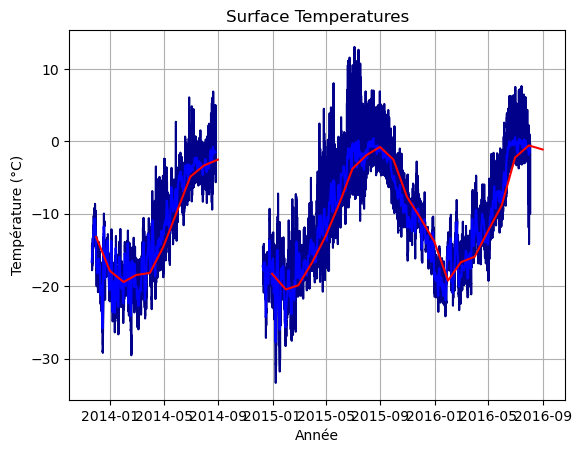

In [58]:
#VARIATIONS DES TEMPERATURES DE SURFACES  
#TM.Tair.plot()
plt.plot(T.time,T['Tair'].values,
    color='darkblue',linestyle='-',label='Tair')
plt.plot(daily_meanT.time,daily_meanT['Tair'].values,
    color='blue',linestyle='-',label='Tair')
plt.plot(monthly_meanT.time,monthly_meanT['Tair'].values,
    color='r',linestyle='-',label='Tair')
plt.title('Surface Temperatures')
plt.xlabel('Année')
plt.ylabel('Température (°C)')
plt.grid(True)